# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
sns.set_context('talk')

# Load data

In [3]:
train = pd.read_pickle('train')

# Prepare data

In [4]:
# Target is whether the virus is detected
y = pd.to_numeric(train.WnvPresent.values)

In [20]:
# These features were selected based on their relative importance
# in other models trained on this dataset
cols_to_use = [
    'Latitude', 'Longitude', 'CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS',
    'CULEX RESTUANS', 'TrapCount', 'PrecipTotalMean', 'Sunrise', 'Sunset',
    'TmaxMean', 'TminMean', 'WetBulbMean', 'Zone1', 'Zone2', 'Zone3', 'Zone4',
    'Zone5', 'Zone6', 'Zone8', 'Zone12', '2009', '2011', '2013'
]

X = train[cols_to_use]

In [21]:
# Split data preserving label ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y)

In [22]:
# Use borderline SMOTE to fix class imbalance
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X_train,
                                                                y_train)

# Ridge Classifier

In [23]:
# Train using CV version of Ridge Classifier to choose best alpha
clf = RidgeClassifierCV()
clf.fit(X_resampled, y_resampled)

# The decision function returns log-liklihood, convert to probablity
d = clf.decision_function(X_test)
clf_probs = np.exp(d) / (1 + np.exp(d))

sig_score = log_loss(y_test, clf_probs)

y_pred = clf.predict(X_test)

# Metrics

In [24]:
# Log loss
print(sig_score)

0.557919033281


In [25]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2489
          1       0.14      0.80      0.24       138

avg / total       0.94      0.74      0.81      2627



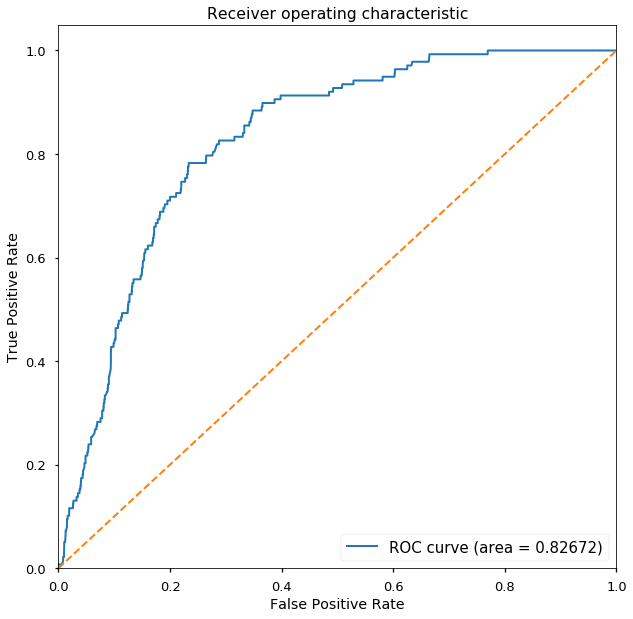

In [26]:
# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, clf_probs)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 10))
lw = 2
ax.plot(fpr, tpr,
         lw=lw, label=f'ROC curve (area = {roc_auc:.5f})')
ax.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right", fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(join('plots', 'Ridge', 'ROC.png'))

In [27]:
# Print coefficients from the model
pd.DataFrame(clf.coef_.T, index=X.columns, columns=['Coefficient'])

,Coefficient
Latitude,-0.020257
Longitude,-1.547292
CULEX PIPIENS/RESTUANS,0.555917
CULEX PIPIENS,0.676447
CULEX RESTUANS,0.276356
TrapCount,0.012282
PrecipTotalMean,1.534187
Sunrise,0.042279
Sunset,0.026459
TmaxMean,-0.042017
